# **Tarea 6 - Sistemas Difusos**
### Estimadores Fuzzy Funcionales
* _Maria Alejandra Bonilla Diaz - 20251595002_ 
* _Alvaro Alejandro Zarabanda Gutierrez – 20251595006_
* _Youssef Alejandro Ortiz Vargas – 20251595004_

Para el diseño de un sistema de inyección electrónica de combustible en motores de automóviles, se observa que es de extrema importancia para el desempeño de la válvula de inyección estimar el volumen de combustible {y} a partir de la medición de tres entradas {x₁, x₂, x₃}.

Un equipo de ingenieros y científicos pretende utilizar un sistema fuzzy basado en el modelo Takagi–Sugeno para mapear el comportamiento del proceso y, así, a partir de los valores de las entradas {x₁, x₂, x₃}, estimar la cantidad de combustible a ser inyectado {y}.

Después de analizar el comportamiento del proceso, y basados en las consideraciones de los especialistas, se proponen los siguientes patrones geométricos para las funciones de pertenencia asociadas a cada una de las variables.

![Enunciado](./assets/enunciado_t6.PNG)

Sabiendo que todas las posibles reglas Rᵢ son del tipo:

> “Si (x₁ es ...) y (x₂ es ...) y (x₃ es ...)  
> Entonces fᵢ(x₁, x₂, x₃)”

realice las siguientes actividades:


## Punto 1:
Obtener las funciones de regresión fᵢ asociadas a cada una de las posibles reglas, evaluando si cada una representa con fidelidad la respectiva aproximación realizada.


#### Desarrollo:
Se quiere estimar un valor y, usando 3 entradas:

- x₁  
- x₂  
- x₃  

Cada entrada tiene solo dos conjuntos difusos:

Para x₁:
- A: triangular (0, 0.30, 0.70)  
- B: triangular (0.30, 0.70, 1.00)

Para x₂:
- A: (0, 0.25, 0.75)  
- B: (0.25, 0.75, 1.00)

Para x₃:
- A: (0, 0.50, 0.80)  
- B: (0.50, 0.80, 1.00)

**Número total de reglas**

Cada variable tiene 2 términos (A y B). Con 3 variable, el número de combinaciones es:

\[
2^3 = 8
\]

**Tabla de reglas**

| Regla | x₁ | x₂ | x₃ |
|------|----|----|----|
| R1   | A  | A  | A  |
| R2   | A  | A  | B  |
| R3   | A  | B  | A  |
| R4   | A  | B  | B  |
| R5   | B  | A  | A  |
| R6   | B  | A  | B  |
| R7   | B  | B  | A  |
| R8   | B  | B  | B  |

El código desarrollado implementa paso a paso el modelo Takagi–Sugeno solicitado, comenzando por la lectura y limpieza del archivo de datos. Luego define las funciones de pertenencia triangulares de acuerdo con los parámetros proporcionados para los términos **A** y **B** de cada variable de entrada. 

A continuación, el programa evalúa cada una de las muestras del conjunto de datos y calcula sus valores de pertenencia correspondientes. Con estos valores, aplica el operador lógico difuso AND utilizando el mínimo, lo cual permite determinar si una muestra activa o no una regla específica del conjunto de ocho reglas definido por las combinaciones posibles de A/B en las tres variables:

- AAA  
- AAB  
- ABA  
- ABB  
- BAA  
- BAB  
- BBA  
- BBB  

El código asigna cada muestra a todas las reglas cuyo grado de activación sea mayor que cero, construyendo así los dominios de activación de cada regla.

Una vez que cada regla tiene asociado un subconjunto de muestras, el código procede a resolver el modelo Takagi–Sugeno mediante la estimación de los coeficientes de las funciones locales de tipo lineal asociadas a cada regla.

Para cada uno de los ocho subconjuntos de datos, el código realiza una regresión lineal múltiple usando la ecuación general:

$$
f_i(x_1, x_2, x_3) = a_i\, x_1 + b_i\, x_2 + c_i\, x_3 + d_i
$$

Esta regresión determina los parámetros $a_i$, $b_i$, $c_i$ y $d_i$ que mejor ajustan los datos que activan la regla $i$, siguiendo el método de mínimos cuadrados. También se calcula el coeficiente de determinación para evaluar la calidad del ajuste.





In [15]:
import numpy as np
import pandas as pd
from funciones import membresia_difusa

# 1. Carga de datos
df = pd.read_csv("assets/tarea6_datos_limpio.csv", sep=";")
df.columns = df.columns.str.strip()
print(df.head())


# Definición de los triángulos

def mu_x1_A(x):
    return membresia_difusa(x, 'triangular', (0.0, 0.30, 0.70))

def mu_x1_B(x):
    return membresia_difusa(x, 'triangular', (0.30, 0.70, 1.0))

def mu_x2_A(x):
    return membresia_difusa(x, 'triangular', (0.0, 0.25, 0.75))

def mu_x2_B(x):
    return membresia_difusa(x, 'triangular', (0.25, 0.75, 1.0))

def mu_x3_A(x):
    return membresia_difusa(x, 'triangular', (0.0, 0.50, 0.80))

def mu_x3_B(x):
    return membresia_difusa(x, 'triangular', (0.50, 0.80, 1.0))

# Definición de las reglas:
reglas = {
    "R1": {"x1": "A", "x2": "A", "x3": "A"},
    "R2": {"x1": "A", "x2": "A", "x3": "B"},
    "R3": {"x1": "A", "x2": "B", "x3": "A"},
    "R4": {"x1": "A", "x2": "B", "x3": "B"},
    "R5": {"x1": "B", "x2": "A", "x3": "A"},
    "R6": {"x1": "B", "x2": "A", "x3": "B"},
    "R7": {"x1": "B", "x2": "B", "x3": "A"},
    "R8": {"x1": "B", "x2": "B", "x3": "B"},
}

# Para guardar los índices (filas) que pertenecen a cada regla
indices_por_regla = {r: [] for r in reglas.keys()}

# Asignación de cada muestra a las reglas
def grado_membresia_variable(var, term, x):
    """Devuelve mu(var_term)(x)."""
    if var == "x1" and term == "A":
        return mu_x1_A(x)
    if var == "x1" and term == "B":
        return mu_x1_B(x)
    if var == "x2" and term == "A":
        return mu_x2_A(x)
    if var == "x2" and term == "B":
        return mu_x2_B(x)
    if var == "x3" and term == "A":
        return mu_x3_A(x)
    if var == "x3" and term == "B":
        return mu_x3_B(x)
    raise ValueError("Variable o término no reconocidos")


for idx, row in df.iterrows():
    x1 = row["x1"]
    x2 = row["x2"]
    x3 = row["x3"]

    # calcular activación de cada regla
    for r_name, r_def in reglas.items():
        mu1 = grado_membresia_variable("x1", r_def["x1"], x1)
        mu2 = grado_membresia_variable("x2", r_def["x2"], x2)
        mu3 = grado_membresia_variable("x3", r_def["x3"], x3)

        mu_rule = min(mu1, mu2, mu3)  # operador Y = mínimo

        # si la regla se activa (mu_rule > 0), la muestra pertenece a esa regla
        if mu_rule > 0:
            indices_por_regla[r_name].append(idx)

# Mostrar cuántas muestras quedaron en cada regla
for r_name in reglas.keys():
    print(f"{r_name}: {len(indices_por_regla[r_name])} muestras")

# Preparación para regresión lineal múltiple

def regresion_por_regla(df, indices):
    subset = df.loc[indices, :]
    X = subset[["x1", "x2", "x3"]].values  # matriz de regresores
    y = subset["f"].values                 # vector objetivo

    # se añade columna de unos para el término independiente (d)
    ones = np.ones((X.shape[0], 1))
    X_design = np.hstack([X, ones])

    # mínimos cuadrados: beta = (a,b,c,d)
    beta, residuals, rank, s = np.linalg.lstsq(X_design, y, rcond=None)
    a, b, c, d = beta

    # cálculo de R^2
    y_pred = X_design @ beta
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    R2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0.0

    return a, b, c, d, R2

   Muestra      x1      x2      x3       f
0        1  0.3644  0.2948  0.3937  0.5240
1        2  0.2014  0.6326  0.9782  0.7143
2        3  0.4039  0.0645  0.4629  0.4547
3        4  0.7137  0.0670  0.2359  0.4602
4        5  0.4277  0.9555  0.0000  0.5477
R1: 81 muestras
R2: 48 muestras
R3: 78 muestras
R4: 46 muestras
R5: 81 muestras
R6: 49 muestras
R7: 77 muestras
R8: 45 muestras


In [16]:
coeficientes = {}

for r_name, idxs in indices_por_regla.items():
    if len(idxs) < 4:
        print(f"Advertencia: {r_name} tiene muy pocas muestras ({len(idxs)}), "
              "la regresión puede no ser confiable.")
        continue

    a, b, c, d, R2 = regresion_por_regla(df, idxs)
    coeficientes[r_name] = {"a": a, "b": b, "c": c, "d": d, "R2": R2}

    print(f"\n=== {r_name} ===")
    print(f"f_{r_name}(x1,x2,x3) = {a:.4f}*x1 + {b:.4f}*x2 + {c:.4f}*x3 + {d:.44f}")
    print(f"R^2 = {R2:.4f}")


print("\n\nRESUMEN DE FUNCIONES POR REGLA:")
for r_name in sorted(coeficientes.keys()):
    a = coeficientes[r_name]["a"]
    b = coeficientes[r_name]["b"]
    c = coeficientes[r_name]["c"]
    d = coeficientes[r_name]["d"]
    R2 = coeficientes[r_name]["R2"]
    print(f"{r_name}: f(x1,x2,x3) = {a:.4f}*x1 + {b:.4f}*x2 + {c:.4f}*x3 + {d:.4f}  |  R^2={R2:.4f}")


=== R1 ===
f_R1(x1,x2,x3) = 0.4297*x1 + 0.4238*x2 + 0.4082*x3 + 0.05503829137050136877107320287905167788267136
R^2 = 0.9932

=== R2 ===
f_R2(x1,x2,x3) = 0.4169*x1 + 0.4235*x2 + 0.2021*x3 + 0.18167980131431743506809084465203341096639633
R^2 = 0.9905

=== R3 ===
f_R3(x1,x2,x3) = 0.4312*x1 + 0.2740*x2 + 0.4014*x3 + 0.12910289612479100562758560499787563458085060
R^2 = 0.9778

=== R4 ===
f_R4(x1,x2,x3) = 0.4257*x1 + 0.2794*x2 + 0.2198*x3 + 0.23753209075974829334043647577345836907625198
R^2 = 0.9790

=== R5 ===
f_R5(x1,x2,x3) = 0.2628*x1 + 0.4246*x2 + 0.4044*x3 + 0.13869034748960568093067990957933943718671799
R^2 = 0.9842

=== R6 ===
f_R6(x1,x2,x3) = 0.2705*x1 + 0.4249*x2 + 0.1855*x3 + 0.26507827144353696136036546704417560249567032
R^2 = 0.9776

=== R7 ===
f_R7(x1,x2,x3) = 0.2733*x1 + 0.2890*x2 + 0.4098*x3 + 0.19373779078901945394086681062617572024464607
R^2 = 0.9700

=== R8 ===
f_R8(x1,x2,x3) = 0.2650*x1 + 0.2872*x2 + 0.1936*x3 + 0.33217788590666430525999430756201036274433136
R^2 = 0.9578


In [17]:
#Resumen de coeficientes
filas_tabla = []

for r_name in sorted(coeficientes.keys()):
    a = coeficientes[r_name]["a"]
    b = coeficientes[r_name]["b"]
    c = coeficientes[r_name]["c"]
    d = coeficientes[r_name]["d"]
    R2 = coeficientes[r_name]["R2"]
    defin = f"(x1={reglas[r_name]['x1']}, x2={reglas[r_name]['x2']}, x3={reglas[r_name]['x3']})"
    n_muestras = len(indices_por_regla[r_name])

    filas_tabla.append({
        "Regla": r_name,
        "Definición": defin,
        "Coef a (x1)": a,
        "Coef b (x2)": b,
        "Coef c (x3)": c,
        "Coef d": d,
        "R²": R2,
        "n muestras": n_muestras
    })

tabla_final = pd.DataFrame(filas_tabla)

print("\n\n==============================")
print(tabla_final.to_string(index=False))





Regla         Definición  Coef a (x1)  Coef b (x2)  Coef c (x3)   Coef d       R²  n muestras
   R1 (x1=A, x2=A, x3=A)     0.429667     0.423757     0.408187 0.055038 0.993202          81
   R2 (x1=A, x2=A, x3=B)     0.416855     0.423508     0.202065 0.181680 0.990464          48
   R3 (x1=A, x2=B, x3=A)     0.431177     0.274043     0.401418 0.129103 0.977847          78
   R4 (x1=A, x2=B, x3=B)     0.425672     0.279433     0.219754 0.237532 0.979001          46
   R5 (x1=B, x2=A, x3=A)     0.262801     0.424629     0.404392 0.138690 0.984244          81
   R6 (x1=B, x2=A, x3=B)     0.270550     0.424939     0.185501 0.265078 0.977551          49
   R7 (x1=B, x2=B, x3=A)     0.273285     0.288998     0.409816 0.193738 0.970003          77
   R8 (x1=B, x2=B, x3=B)     0.264951     0.287184     0.193613 0.332178 0.957765          45


## Punto 2:
Elaborar los procedimientos computacionales para obtener los valores de salida del método Takagi-Sugeno en función de las contribuciones resultantes de todas las reglas activas. 

#### Desarrollo:

En este punto se desarrollan las funciones que calculan:

- El grado de activación de cada regla.
- La salida local de cada función lineal asociada a la regla.
- La agregación ponderada de todas las reglas activas que conforma la salida global del sistema TS tipo 1.

**Cálculo del grado de activación de cada regla**

Para evaluar una regla del sistema Takagi–Sugeno, primero se determinan los grados de pertenencia de cada entrada a los conjuntos difusos correspondientes.  
Dado que las reglas están formadas por combinaciones de A/B en las variables **x₁, x₂ y x₃**, el sistema calcula:

- $ \mu_{x_1}(A) $ o $ \mu_{x_1}(B) $  
- $ \mu_{x_2}(A) $ o $ \mu_{x_2}(B) $  
- $ \mu_{x_3}(A) $ o $ \mu_{x_3}(B) $  

usando las funciones de pertenencia triangulares definidas previamente.

**Activación conjunta de la regla**

Para determinar el grado de activación total de una regla, se aplica el operador lógico difuso AND, definido como el mínimo:

$$
\mu_i = \min\{\, \mu_{x_1}(t_1),\; \mu_{x_2}(t_2),\; \mu_{x_3}(t_3) \,\}
$$

donde $t_1, t_2, t_3 \in \{A, B\}$ son los términos lingüísticos correspondientes a la regla evaluada.

El código implementa este cálculo mediante la función: salida_regla(nombre_regla, x1, x2, x3)

que devuelve dos valores fundamentales:

- $ \mu_i $: grado de activación de la regla.  
- $ f_i(x_1, x_2, x_3) $: salida local de la regla según su función lineal asociada.

**Integración de las reglas: salida global Takagi–Sugeno**

La salida final del modelo TS se obtiene combinando todas las reglas activas mediante un promedio ponderado, donde el peso de cada función local es su grado de activación:

$$
y = \frac{\sum_{i=1}^{8} \mu_i\, f_i}{\sum_{i=1}^{8} \mu_i}
$$

Este mecanismo garantiza que:

- Si una regla no se activa ($\mu_i = 0$), no contribuye.
- Si varias reglas se activan simultáneamente, todas influyen según su magnitud.
- La transición entre regiones del espacio se realiza de manera suave, cumpliendo la propiedad difusa deseable.

El código organiza todo este proceso en la función: salida_takagi_sugeno(x1, x2, x3)



In [18]:
def salida_regla(r_name, x1, x2, x3):
    term_x1 = reglas[r_name]["x1"]
    term_x2 = reglas[r_name]["x2"]
    term_x3 = reglas[r_name]["x3"]

    mu1 = grado_membresia_variable("x1", term_x1, x1)
    mu2 = grado_membresia_variable("x2", term_x2, x2)
    mu3 = grado_membresia_variable("x3", term_x3, x3)

    mu_i = min(mu1, mu2, mu3)

    if mu_i == 0:
        return 0.0, 0.0

    # coeficientes de la regresión de la regla 
    a = coeficientes[r_name]["a"]
    b = coeficientes[r_name]["b"]
    c = coeficientes[r_name]["c"]
    d = coeficientes[r_name]["d"]

    # salida local de la regla
    f_i = a * x1 + b * x2 + c * x3 + d

    return mu_i, f_i


def salida_takagi_sugeno(x1, x2, x3, verbose=False):
    """
    Implementa el método TS tipo 1:
      y = sum(mu_i * f_i) / sum(mu_i)
    considerando todas las reglas activas.
    """
    suma_num = 0.0
    suma_den = 0.0

    for r_name in sorted(reglas.keys()):
        if r_name not in coeficientes:
            continue

        mu_i, f_i = salida_regla(r_name, x1, x2, x3)

        if mu_i > 0:
            if verbose:
                print(f"{r_name}: mu={mu_i:.4f}, f_i={f_i:.4f}, contrib={mu_i * f_i:.4f}")
            suma_num += mu_i * f_i
            suma_den += mu_i

    if suma_den == 0:
        return 0.0

    y = suma_num / suma_den
    return y



In [19]:
print("\n\n==============================")
print(" DEMOSTRACIÓN DEL PUNTO 2")
print("==============================")

# Punto de prueba cualquiera (NO uno de los del Punto 3)
x1_demo, x2_demo, x3_demo = 0.5, 0.4, 0.6

print(f"\nPunto de prueba: x1={x1_demo}, x2={x2_demo}, x3={x3_demo}\n")

for r in sorted(reglas.keys()):
    if r not in coeficientes:
        continue
    mu_i, f_i = salida_regla(r, x1_demo, x2_demo, x3_demo)
    print(f"{r}: mu={mu_i:.4f}, f_i={f_i:.4f}")




 DEMOSTRACIÓN DEL PUNTO 2

Punto de prueba: x1=0.5, x2=0.4, x3=0.6

R1: mu=0.5000, f_i=0.6843
R2: mu=0.3333, f_i=0.6807
R3: mu=0.3000, f_i=0.6952
R4: mu=0.3000, f_i=0.6940
R5: mu=0.5000, f_i=0.6826
R6: mu=0.3333, f_i=0.6816
R7: mu=0.3000, f_i=0.6919
R8: mu=0.3000, f_i=0.6957


## Punto 3:

Considere los siguientes valores de $x_1$, $x_2$ y $x_3$ que fueron adquiridos en tiempo real por los instrumentos de medición del proceso:

a) $x_1 = 0.1399$, $x_2 = 0.1610$, $x_3 = 0.2477$  
b) $x_1 = 0.9430$, $x_2 = 0.4476$, $x_3 = 0.2648$  
c) $x_1 = 0.0004$, $x_2 = 0.6916$, $x_3 = 0.5006$  
d) $x_1 = 0.5102$, $x_2 = 0.7464$, $x_3 = 0.0860$  
e) $x_1 = 0.0611$, $x_2 = 0.2860$, $x_3 = 0.7464$

Determine, para cada uno de los anteriores valores, el valor final de salida del sistema fuzzy, considerando la contribución de cada una de las reglas activas y sus respectivas funciones de regresión, listando cuáles reglas fuzzy están asociadas con el cálculo del resultado final del sistema fuzzy.

- Utilizar 1000 puntos de discretización para todos los universos de discurso.  
- Utilizar el operador mínimo para el conectivo “Y”.  
- Utilizar como operador de ponderación (“agregación”) la Media Ponderada.


#### Desarrollo:
En este punto se presentan los resultados del proceso de evaluación del modelo difuso Takagi–Sugeno (TS) para los cinco conjuntos de valores $(x_1, x_2, x_3)$ adquiridos en tiempo real.

Para cada caso se muestran:

- Las funciones de pertenencia activadas en cada variable.
- Las reglas difusas activas y sus pesos de activación.
- Las funciones locales de regresión evaluadas.
- La salida final, obtenida mediante media ponderada de las contribuciones de cada regla activa.
- Las gráficas de pertenencia para cada universo $x_1$, $x_2$, $x_3$ usando 1000 puntos de discretización.

En todos los casos se emplearon:

- 1000 puntos de discretización por universo de discurso.
- Conectivo AND implementado como el mínimo.
- Agregación mediante la Media Ponderada:

$$
y_{TS} = \frac{\sum_i \mu_i\, f_i}{\sum_i \mu_i}
$$

El código imprime automáticamente:

- Regla activa
- Peso de activación $\mu_i$
- Valor $f_i$
- Contribución $\mu_i f_i$

Para cada caso se generan tres gráficas, correspondientes a los universos $x_1$, $x_2$ y $x_3$:

- Curvas de pertenencia de los términos A y B.
- Línea vertical indicando el valor medido.
- Punto marcado mostrando el nivel de pertenencia a cada conjunto.





1.3. Caso a,  Valor de x1 = 0.1399  y x2 = 0.161  y x3 = 0.2477

Funciones y reglas activadas:

Funciones activadas en x1:
  x1 es A: 0.466
  x1 es B: 0.000

Funciones activadas en x2:
  x2 es A: 0.644
  x2 es B: 0.000

Funciones activadas en x3:
  x3 es A: 0.495
  x3 es B: 0.000

Reglas activadas:
  R1: (x1=A, x2=A, x3=A), w=0.466, f_i=0.284

Valores de pertenencia de cada uno de los universos:



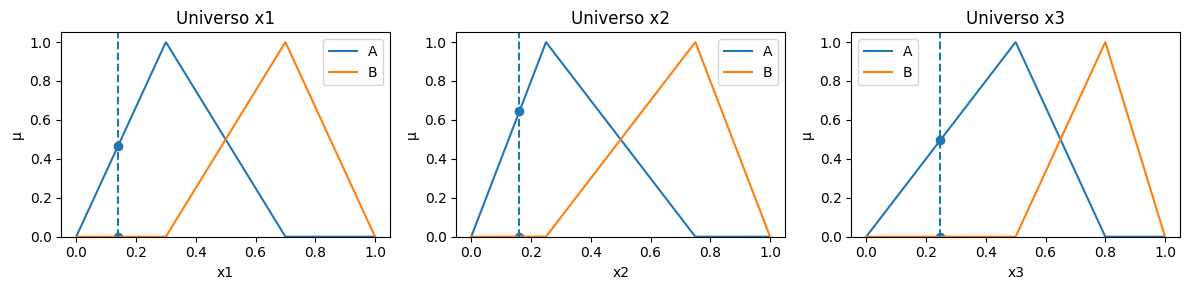

Resultado final:

  Salida final (media ponderada) = 0.2845

  Detalle de reglas activas:
    R1: (A, A, A), w=0.466, f_i=0.284

------------------------------------------------------------


1.3. Caso b,  Valor de x1 = 0.943  y x2 = 0.4476  y x3 = 0.2648

Funciones y reglas activadas:

Funciones activadas en x1:
  x1 es A: 0.000
  x1 es B: 0.190

Funciones activadas en x2:
  x2 es A: 0.605
  x2 es B: 0.395

Funciones activadas en x3:
  x3 es A: 0.530
  x3 es B: 0.000

Reglas activadas:
  R5: (x1=B, x2=A, x3=A), w=0.190, f_i=0.684
  R7: (x1=B, x2=B, x3=A), w=0.190, f_i=0.689

Valores de pertenencia de cada uno de los universos:



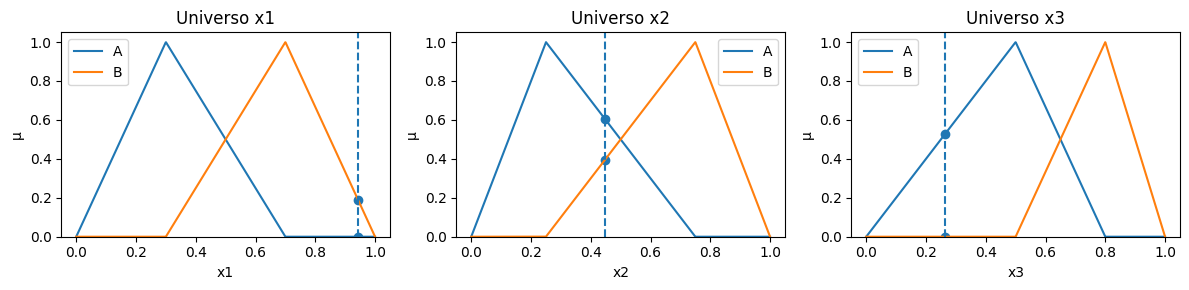

Resultado final:

  Salida final (media ponderada) = 0.6865

  Detalle de reglas activas:
    R5: (B, A, A), w=0.190, f_i=0.684
    R7: (B, B, A), w=0.190, f_i=0.689

------------------------------------------------------------


1.3. Caso c,  Valor de x1 = 0.0004  y x2 = 0.6916  y x3 = 0.5006

Funciones y reglas activadas:

Funciones activadas en x1:
  x1 es A: 0.001
  x1 es B: 0.000

Funciones activadas en x2:
  x2 es A: 0.117
  x2 es B: 0.883

Funciones activadas en x3:
  x3 es A: 0.998
  x3 es B: 0.002

Reglas activadas:
  R1: (x1=A, x2=A, x3=A), w=0.001, f_i=0.553
  R2: (x1=A, x2=A, x3=B), w=0.001, f_i=0.576
  R3: (x1=A, x2=B, x3=A), w=0.001, f_i=0.520
  R4: (x1=A, x2=B, x3=B), w=0.001, f_i=0.541

Valores de pertenencia de cada uno de los universos:



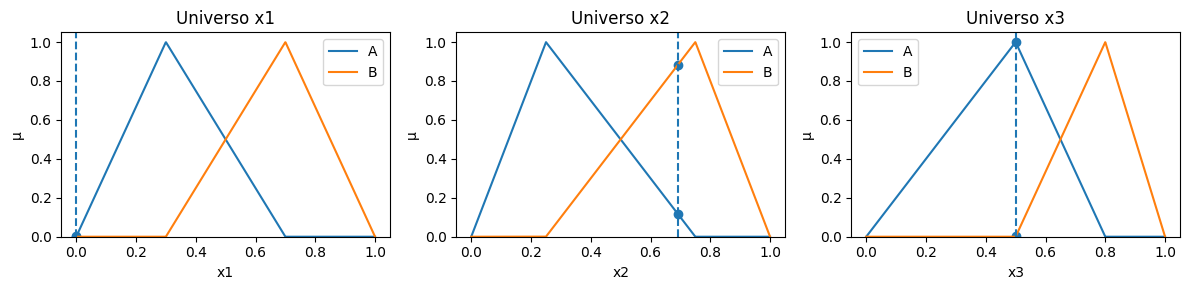

Resultado final:

  Salida final (media ponderada) = 0.5473

  Detalle de reglas activas:
    R1: (A, A, A), w=0.001, f_i=0.553
    R2: (A, A, B), w=0.001, f_i=0.576
    R3: (A, B, A), w=0.001, f_i=0.520
    R4: (A, B, B), w=0.001, f_i=0.541

------------------------------------------------------------


1.3. Caso d,  Valor de x1 = 0.5102  y x2 = 0.7464  y x3 = 0.086

Funciones y reglas activadas:

Funciones activadas en x1:
  x1 es A: 0.474
  x1 es B: 0.526

Funciones activadas en x2:
  x2 es A: 0.007
  x2 es B: 0.993

Funciones activadas en x3:
  x3 es A: 0.172
  x3 es B: 0.000

Reglas activadas:
  R1: (x1=A, x2=A, x3=A), w=0.007, f_i=0.626
  R3: (x1=A, x2=B, x3=A), w=0.172, f_i=0.588
  R5: (x1=B, x2=A, x3=A), w=0.007, f_i=0.624
  R7: (x1=B, x2=B, x3=A), w=0.172, f_i=0.584

Valores de pertenencia de cada uno de los universos:



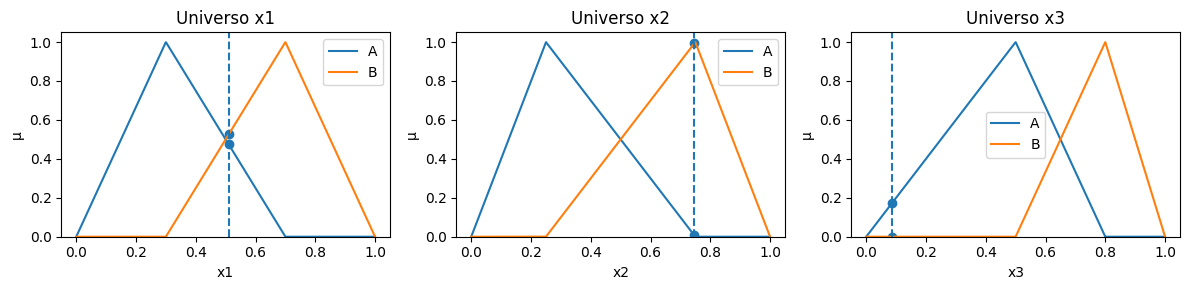

Resultado final:

  Salida final (media ponderada) = 0.5877

  Detalle de reglas activas:
    R1: (A, A, A), w=0.007, f_i=0.626
    R3: (A, B, A), w=0.172, f_i=0.588
    R5: (B, A, A), w=0.007, f_i=0.624
    R7: (B, B, A), w=0.172, f_i=0.584

------------------------------------------------------------


1.3. Caso e,  Valor de x1 = 0.0611  y x2 = 0.286  y x3 = 0.7464

Funciones y reglas activadas:

Funciones activadas en x1:
  x1 es A: 0.204
  x1 es B: 0.000

Funciones activadas en x2:
  x2 es A: 0.928
  x2 es B: 0.072

Funciones activadas en x3:
  x3 es A: 0.179
  x3 es B: 0.821

Reglas activadas:
  R1: (x1=A, x2=A, x3=A), w=0.179, f_i=0.507
  R2: (x1=A, x2=A, x3=B), w=0.204, f_i=0.479
  R3: (x1=A, x2=B, x3=A), w=0.072, f_i=0.533
  R4: (x1=A, x2=B, x3=B), w=0.072, f_i=0.507

Valores de pertenencia de cada uno de los universos:



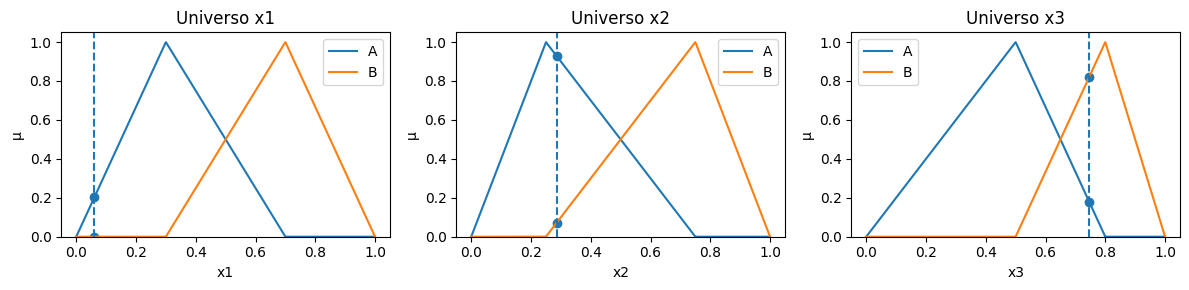

Resultado final:

  Salida final (media ponderada) = 0.4999

  Detalle de reglas activas:
    R1: (A, A, A), w=0.179, f_i=0.507
    R2: (A, A, B), w=0.204, f_i=0.479
    R3: (A, B, A), w=0.072, f_i=0.533
    R4: (A, B, B), w=0.072, f_i=0.507

------------------------------------------------------------



In [20]:
import matplotlib.pyplot as plt

#Definición de los casos a evaluar
casos = {
    "a": {"x1": 0.1399, "x2": 0.1610, "x3": 0.2477},
    "b": {"x1": 0.9430, "x2": 0.4476, "x3": 0.2648},
    "c": {"x1": 0.0004, "x2": 0.6916, "x3": 0.5006},
    "d": {"x1": 0.5102, "x2": 0.7464, "x3": 0.0860},
    "e": {"x1": 0.0611, "x2": 0.2860, "x3": 0.7464},
}

def mostrar_caso_con_graficas(nombre_caso, x1, x2, x3):
    print("\n" + "="*60)
    print(f"1.3. Caso {nombre_caso},  Valor de x1 = {x1}  y x2 = {x2}  y x3 = {x3}")
    print("="*60 + "\n")

# 1) Funciones activadas en x1, x2, x3

    mu_x1A = mu_x1_A(x1)
    mu_x1B = mu_x1_B(x1)
    mu_x2A = mu_x2_A(x2)
    mu_x2B = mu_x2_B(x2)
    mu_x3A = mu_x3_A(x3)
    mu_x3B = mu_x3_B(x3)

    print("Funciones y reglas activadas:\n")

    print("Funciones activadas en x1:")
    print(f"  x1 es A: {mu_x1A:.3f}")
    print(f"  x1 es B: {mu_x1B:.3f}\n")

    print("Funciones activadas en x2:")
    print(f"  x2 es A: {mu_x2A:.3f}")
    print(f"  x2 es B: {mu_x2B:.3f}\n")

    print("Funciones activadas en x3:")
    print(f"  x3 es A: {mu_x3A:.3f}")
    print(f"  x3 es B: {mu_x3B:.3f}\n")

# 2) Reglas activas, pesos y f_i

    suma_num = 0.0
    suma_den = 0.0
    reglas_activas = []

    print("Reglas activadas:")

    for r_name in sorted(reglas.keys()):
        if r_name not in coeficientes:
            continue

        mu_i, f_i = salida_regla(r_name, x1, x2, x3)

        if mu_i > 0:
            contrib = mu_i * f_i
            reglas_activas.append((r_name, mu_i, f_i, contrib))
            suma_num += contrib
            suma_den += mu_i

            print(f"  {r_name}: (x1={reglas[r_name]['x1']}, "
                  f"x2={reglas[r_name]['x2']}, x3={reglas[r_name]['x3']}), "
                  f"w={mu_i:.3f}, f_i={f_i:.3f}")

    if suma_den == 0:
        y_ts = 0.0
    else:
        y_ts = suma_num / suma_den


# 3) Gráficas de pertenencia (Universos x1,x2,x3)

    print("\nValores de pertenencia de cada uno de los universos:\n")

    xs = np.linspace(0, 1, 1000)  # 1000 puntos de discretización

    plt.figure(figsize=(12, 3))

    # Universo x1
    plt.subplot(1, 3, 1)
    muA_x1 = [mu_x1_A(v) for v in xs]
    muB_x1 = [mu_x1_B(v) for v in xs]
    plt.plot(xs, muA_x1, label="A")
    plt.plot(xs, muB_x1, label="B")
    plt.axvline(x1, linestyle="--")
    plt.scatter([x1, x1], [mu_x1A, mu_x1B])
    plt.title("Universo x1")
    plt.xlabel("x1")
    plt.ylabel("μ")
    plt.ylim(0, 1.05)
    plt.legend()

    # Universo x2
    plt.subplot(1, 3, 2)
    muA_x2 = [mu_x2_A(v) for v in xs]
    muB_x2 = [mu_x2_B(v) for v in xs]
    plt.plot(xs, muA_x2, label="A")
    plt.plot(xs, muB_x2, label="B")
    plt.axvline(x2, linestyle="--")
    plt.scatter([x2, x2], [mu_x2A, mu_x2B])
    plt.title("Universo x2")
    plt.xlabel("x2")
    plt.ylabel("μ")
    plt.ylim(0, 1.05)
    plt.legend()

    # Universo x3
    plt.subplot(1, 3, 3)
    muA_x3 = [mu_x3_A(v) for v in xs]
    muB_x3 = [mu_x3_B(v) for v in xs]
    plt.plot(xs, muA_x3, label="A")
    plt.plot(xs, muB_x3, label="B")
    plt.axvline(x3, linestyle="--")
    plt.scatter([x3, x3], [mu_x3A, mu_x3B])
    plt.title("Universo x3")
    plt.xlabel("x3")
    plt.ylabel("μ")
    plt.ylim(0, 1.05)
    plt.legend()

    plt.tight_layout()
    plt.show()

# 4) Resultado final

    print("Resultado final:\n")
    print(f"  Salida final (media ponderada) = {y_ts:.4f}\n")
    print("  Detalle de reglas activas:")
    for r_name, mu_i, f_i, contrib in reglas_activas:
        print(f"    {r_name}: ({reglas[r_name]['x1']}, "
              f"{reglas[r_name]['x2']}, {reglas[r_name]['x3']}), "
              f"w={mu_i:.3f}, f_i={f_i:.3f}")
    print("\n" + "-"*60 + "\n")


# Llamar la función para cada caso (a–e)
for nombre, vals in casos.items():
    mostrar_caso_con_graficas(nombre,
                              vals["x1"],
                              vals["x2"],
                              vals["x3"])